# Wikipedia Indexing with ColBERT

In [8]:
# conda install polars pandas seaborn tqdm -c conda-forge
# !pip install rank_bm25
# !pip install -e './ColBERT'

In [6]:
# conda upgrade numpy -c conda-forge
# # conda install -c conda-forge faiss-gpu

In [1]:
import os
import glob
import polars as pl
import polars.selectors as cs
import pandas as pd
import pyarrow as pa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from pathlib import Path
import faiss

from rank_bm25 import BM25Okapi
from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert.data import Queries, Collection
from colbert import Indexer, Searcher

/home/daniel/mambaforge/envs/pytorch/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pl.Config(fmt_str_lengths=2000);

In [3]:
# conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia -y

In [4]:
#!pip install rank_bm25

In [5]:
# !conda list | grep bitsandbytes

In [6]:
# !conda install -c conda-forge pyarrow -y

In [7]:
# !conda update -c conda-forge 'auto-gptq[triton]' -y

In [8]:
# huggingface_hub.login(os.environ['HUGGING_FACE_TOKEN'])

In [9]:
questions = pl.read_parquet('./data/daniel_train/v_1_combined/daniel_train_v_1.parquet')
questions = questions.filter(pl.col('question').is_not_null())
questions.shape, np.array(questions.columns)

((5799, 8),
 array(['question', 'correct', 'incorrect_1', 'incorrect_2', 'incorrect_3',
        'incorrect_4', 'title', 'section_title'], dtype='<U13'))

In [10]:
wiki_sections = pl.read_parquet('./data/wiki_with_category_v_4.parquet')
section_word_counts = wiki_sections['section_text'].str.split(' ').list.lengths()
wiki_sections = wiki_sections.with_columns(section_word_count=pl.Series(section_word_counts))

wiki_sections = wiki_sections.filter(pl.col('section_word_count') > 11)
wiki_sections.shape, np.array(wiki_sections.columns) # 833,300 sections

((827713, 16),
 array(['section_id', 'title', 'category', 'page_id', 'parent_id',
        'revision_id', 'revision_ts', 'short_description', 'sha1',
        'page_bytes', 'section_index', 'section_title', 'section_level',
        'section_text', 'title_section_rank', 'section_word_count'],
       dtype='<U18'))

In [11]:
wiki_sections['title'].n_unique()

154105

'Mean word count: 207, median: 120'

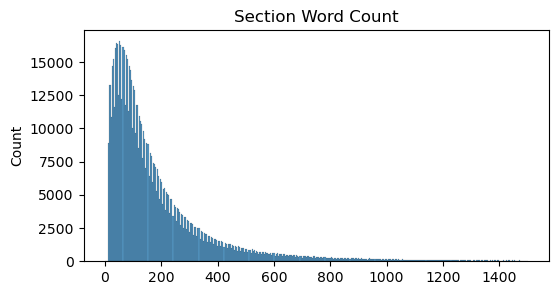

In [12]:
plt.figure(figsize=[6,3])
sns.histplot(wiki_sections['section_word_count'], binrange=[0, 1500])
plt.title('Section Word Count')
f'Mean word count: {section_word_counts.mean():.0f}, median: {section_word_counts.median():.0f}'

In [13]:
wiki_sections.filter(pl.col('title').str.starts_with('List of'))

section_id,title,category,page_id,parent_id,revision_id,revision_ts,short_description,sha1,page_bytes,section_index,section_title,section_level,section_text,title_section_rank,section_word_count
u32,str,str,i64,i64,i64,datetime[μs],str,str,i64,i64,str,i64,str,u32,u32


In [14]:
# wiki_sections.sample(20)[['title', 'section_title', 'section_text']]

In [15]:
# with pl.Config() as cfg:
#     cfg.set_tbl_rows(100)
#     display(wiki_sections.filter(pl.col('section_word_count') < 15)[['title', 'section_title', 'section_text']])

In [16]:
max_words = 100
doc_maxlen = 150
query_maxlen = 150
nbits = 1
colbert_path = Path(f'./data/colbert_max_words_{max_words}_nbits_{nbits}-v5')
os.makedirs(colbert_path, exist_ok=True)

In [17]:
def split_text_into_chunks(text):
    chunks = []
    current_chunk = []
    current_length = 0
    last_period = -1
    section_words = text.split()

    remaining_words = list(section_words)
    split_sum = 0
    for word in section_words:
        current_length += 1
        if word.endswith('.'):
            last_period = current_length
        
        if current_length == max_words:
            if last_period > -1:
                chunk = remaining_words[:last_period]
                chunks.append(" ".join(chunk))
                remaining_words = remaining_words[last_period:]             
                current_length = current_length - last_period
                split_sum += last_period
            else:
                # If no period exists, just split it at max_words
                chunk = remaining_words[:current_length]
                chunks.append(" ".join(chunk))
                remaining_words = remaining_words[current_length:]
                current_length = 0
                split_sum += current_length
            last_period = -1

    if remaining_words:
        chunks.append(" ".join(remaining_words))
    
    return chunks

passages = wiki_sections[['section_id', 'title', 'section_title', 'section_index', 'section_text']]
passages = passages.with_columns(
    pl.col("section_text")
      .map_elements(split_text_into_chunks)\
      .cast(pl.List(pl.Utf8)).alias('passage_text')\
)
passages = passages.drop('section_text')
passages = passages.explode('passage_text')

passages = passages.with_columns(pl.col('title')\
                   .rank(method="ordinal")\
                   .over(['title', 'section_index', 'section_title', 'passage_text'])\
                   .alias('title_section_rank'))
passages = passages.filter(pl.col('title_section_rank') == 1)
passages = passages.filter(pl.col('passage_text').is_not_null())\
                   .with_row_count('passage_id')

passages = passages.with_columns(pl.col('passage_text').str.replace_all('\n', ' '))                      
passages_file = colbert_path/'wiki_passages'
passages.write_parquet(str(passages_file) +'.parquet')
passages = passages.with_columns(pl.col('passage_id').rank(method="min").over(["section_id"]).alias('section_passage_num'))

# \s: Matches any whitespace character, including spaces, tabs, and newline characters.
# \S: Matches any character that is NOT a whitespace character.
passages = passages.with_columns(pl.col('section_title').str.replace_all('<ref[^>]*>[\s\S]*?<\/ref>', ''))
passages = passages.with_columns(pl.col('passage_text').str.replace_all('<ref[^>]*>[\s\S]*?<\/ref>', ''))
passages = passages.with_columns(titled_passage=pl.col('title') +\
                                  ':' + pl.col('section_title') + ':'\
                                  + pl.col('passage_text').str.replace_all(r"[\n\t]+$", ""))
passages.shape, passages.columns # 2,500,036 of max_words 100

((2396792, 9),
 ['passage_id',
  'section_id',
  'title',
  'section_title',
  'section_index',
  'passage_text',
  'title_section_rank',
  'section_passage_num',
  'titled_passage'])

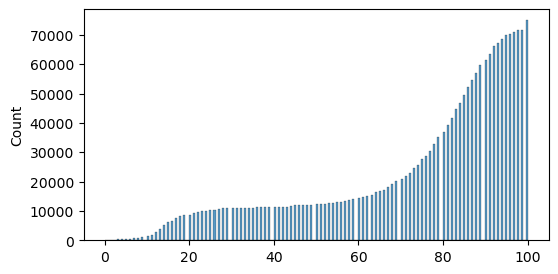

In [18]:
plt.figure(figsize=[6,3])
sns.histplot(passages['titled_passage'].str.split(' ').list.lengths(), binrange=[0, max_words]);

In [19]:
# def split_text_into_chunks(text):
#     chunks = []
#     current_chunk = []
#     current_length = 0
#     last_period = -1
#     section_words = text.split()

#     remaining_words = list(section_words)
#     split_sum = 0
#     for word in section_words:
#         current_length += 1
#         if word.endswith('.'):
#             last_period = current_length
        
#         if current_length == max_words:
#             if last_period > -1:
#                 chunk = remaining_words[:last_period]
#                 chunks.append(" ".join(chunk))
#                 remaining_words = remaining_words[last_period:]             
#                 current_length = current_length - last_period
#                 split_sum += last_period
#             else:
#                 # If no period exists, just split it at max_words
#                 chunk = remaining_words[:current_length]
#                 chunks.append(" ".join(chunk))
#                 remaining_words = remaining_words[current_length:]
#                 current_length = 0
#                 split_sum += current_length
#             last_period = -1

#     if remaining_words:
#         chunks.append(" ".join(remaining_words))
    
#     return chunks

# passages = wiki_sections[['section_Aid', 'title', 'section_title', 'section_index', 'section_text']]
# passages = passages.with_columns(
#     pl.col("section_text")
#       .map_elements(split_text_into_chunks)\
#       .cast(pl.List(pl.Utf8)).alias('passage_text')\
# )
# passages = passages.drop('section_text')
# passages = passages.explode('passage_text')
passages.filter(passages.drop('section_id').is_duplicated()).sort(['title', 'section_title', 'section_index', 'passage_text'])

passage_id,section_id,title,section_title,section_index,passage_text,title_section_rank,section_passage_num,titled_passage
u32,u32,str,str,i64,str,u32,u32,str


## Using ColBERT to find Wiki Section

In [20]:
checkpoint = './checkpoints/colbertv2.0'
indexer_name = f"colbert_wiki_indexer"

passages[['passage_id', 'titled_passage']].write_csv(str(passages_file) + '.tsv', separator='\t', has_header=False)
c_collection = Collection(str(passages_file) + '.tsv')
f'Loaded {len(c_collection):,} passages'

os.environ['COLBERT_LOAD_TORCH_EXTENSION_VERBOSE'] = 'True'

config = ColBERTConfig(
    doc_maxlen=doc_maxlen,
    query_maxlen=query_maxlen, 
    nbits=nbits
)

[Sep 23, 16:49:35] #> Loading collection...
0M 1M 2M 


In [21]:
rerun = True
if rerun:
    with Run().context(RunConfig(nranks=1, index_root=str(colbert_path))):
        indexer = Indexer(checkpoint=checkpoint, config=config)
        indexer.index(name=indexer_name,
                      collection=c_collection,
                      overwrite=True)



[Sep 23, 16:49:37] #> Creating directory data/colbert_max_words_100_nbits_1-v5/colbert_wiki_indexer 


#> Starting...
nranks = 1 	 num_gpus = 1 	 device=0
{
    "query_token_id": "[unused0]",
    "doc_token_id": "[unused1]",
    "query_token": "[Q]",
    "doc_token": "[D]",
    "ncells": null,
    "centroid_score_threshold": null,
    "ndocs": null,
    "index_path": null,
    "nbits": 1,
    "kmeans_niters": 20,
    "resume": false,
    "similarity": "cosine",
    "bsize": 64,
    "accumsteps": 1,
    "lr": 1e-5,
    "maxsteps": 400000,
    "save_every": null,
    "warmup": 20000,
    "warmup_bert": null,
    "relu": false,
    "nway": 64,
    "use_ib_negatives": true,
    "reranker": false,
    "distillation_alpha": 1.0,
    "ignore_scores": false,
    "model_name": null,
    "query_maxlen": 150,
    "attend_to_mask_tokens": false,
    "interaction": "colbert",
    "dim": 128,
    "doc_maxlen": 150,
    "mask_punctuation": true,
    "checkpoint": ".\/checkpoints\/colbertv2.0",
    

Using /home/daniel/.cache/torch_extensions/py310_cu118 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/daniel/.cache/torch_extensions/py310_cu118/decompress_residuals_cpp/build.ninja...
Building extension module decompress_residuals_cpp...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module decompress_residuals_cpp...
Using /home/daniel/.cache/torch_extensions/py310_cu118 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/daniel/.cache/torch_extensions/py310_cu118/packbits_cpp/build.ninja...
Building extension module packbits_cpp...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module packbits_cpp...
0it [00:00, ?it/s]

[Sep 23, 17:08:56] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:09:10] [0] 		 #> Saving chunk 0: 	 25,000 passages and 2,514,054 embeddings. From #0 onward.


1it [00:15, 15.39s/it]

[Sep 23, 17:09:12] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:09:25] [0] 		 #> Saving chunk 1: 	 25,000 passages and 2,536,381 embeddings. From #25,000 onward.


2it [00:30, 15.29s/it]

[Sep 23, 17:09:27] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:09:41] [0] 		 #> Saving chunk 2: 	 25,000 passages and 2,465,671 embeddings. From #50,000 onward.


3it [00:45, 15.24s/it]

[Sep 23, 17:09:42] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:09:56] [0] 		 #> Saving chunk 3: 	 25,000 passages and 2,502,451 embeddings. From #75,000 onward.


4it [01:01, 15.26s/it]

[Sep 23, 17:09:57] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:10:11] [0] 		 #> Saving chunk 4: 	 25,000 passages and 2,518,696 embeddings. From #100,000 onward.


5it [01:16, 15.30s/it]

[Sep 23, 17:10:13] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:10:26] [0] 		 #> Saving chunk 5: 	 25,000 passages and 2,521,527 embeddings. From #125,000 onward.


6it [01:31, 15.28s/it]

[Sep 23, 17:10:28] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:10:42] [0] 		 #> Saving chunk 6: 	 25,000 passages and 2,513,895 embeddings. From #150,000 onward.


7it [01:46, 15.27s/it]

[Sep 23, 17:10:43] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:10:57] [0] 		 #> Saving chunk 7: 	 25,000 passages and 2,536,249 embeddings. From #175,000 onward.


8it [02:02, 15.26s/it]

[Sep 23, 17:10:59] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:11:12] [0] 		 #> Saving chunk 8: 	 25,000 passages and 2,448,831 embeddings. From #200,000 onward.


9it [02:17, 15.23s/it]

[Sep 23, 17:11:14] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:11:28] [0] 		 #> Saving chunk 9: 	 25,000 passages and 2,504,737 embeddings. From #225,000 onward.


10it [02:32, 15.28s/it]

[Sep 23, 17:11:29] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:11:43] [0] 		 #> Saving chunk 10: 	 25,000 passages and 2,528,385 embeddings. From #250,000 onward.


11it [02:48, 15.27s/it]

[Sep 23, 17:11:44] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:11:58] [0] 		 #> Saving chunk 11: 	 25,000 passages and 2,521,046 embeddings. From #275,000 onward.


12it [03:03, 15.27s/it]

[Sep 23, 17:12:00] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:12:13] [0] 		 #> Saving chunk 12: 	 25,000 passages and 2,518,252 embeddings. From #300,000 onward.


13it [03:18, 15.27s/it]

[Sep 23, 17:12:15] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:12:29] [0] 		 #> Saving chunk 13: 	 25,000 passages and 2,545,243 embeddings. From #325,000 onward.


14it [03:33, 15.31s/it]

[Sep 23, 17:12:30] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:12:44] [0] 		 #> Saving chunk 14: 	 25,000 passages and 2,450,535 embeddings. From #350,000 onward.


15it [03:49, 15.27s/it]

[Sep 23, 17:12:46] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:12:59] [0] 		 #> Saving chunk 15: 	 25,000 passages and 2,491,506 embeddings. From #375,000 onward.


16it [04:04, 15.26s/it]

[Sep 23, 17:13:01] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:13:14] [0] 		 #> Saving chunk 16: 	 25,000 passages and 2,511,432 embeddings. From #400,000 onward.


17it [04:19, 15.26s/it]

[Sep 23, 17:13:16] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:13:30] [0] 		 #> Saving chunk 17: 	 25,000 passages and 2,524,358 embeddings. From #425,000 onward.


18it [04:35, 15.31s/it]

[Sep 23, 17:13:31] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:13:45] [0] 		 #> Saving chunk 18: 	 25,000 passages and 2,508,514 embeddings. From #450,000 onward.


19it [04:50, 15.30s/it]

[Sep 23, 17:13:47] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:14:00] [0] 		 #> Saving chunk 19: 	 25,000 passages and 2,541,259 embeddings. From #475,000 onward.


20it [05:05, 15.29s/it]

[Sep 23, 17:14:02] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:14:16] [0] 		 #> Saving chunk 20: 	 25,000 passages and 2,445,172 embeddings. From #500,000 onward.


21it [05:20, 15.25s/it]

[Sep 23, 17:14:17] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:14:31] [0] 		 #> Saving chunk 21: 	 25,000 passages and 2,510,216 embeddings. From #525,000 onward.


22it [05:36, 15.29s/it]

[Sep 23, 17:14:33] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:14:46] [0] 		 #> Saving chunk 22: 	 25,000 passages and 2,512,227 embeddings. From #550,000 onward.


23it [05:51, 15.28s/it]

[Sep 23, 17:14:48] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:15:01] [0] 		 #> Saving chunk 23: 	 25,000 passages and 2,524,881 embeddings. From #575,000 onward.


24it [06:06, 15.27s/it]

[Sep 23, 17:15:03] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:15:17] [0] 		 #> Saving chunk 24: 	 25,000 passages and 2,513,437 embeddings. From #600,000 onward.


25it [06:21, 15.27s/it]

[Sep 23, 17:15:18] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:15:32] [0] 		 #> Saving chunk 25: 	 25,000 passages and 2,540,111 embeddings. From #625,000 onward.


26it [06:37, 15.32s/it]

[Sep 23, 17:15:34] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:15:47] [0] 		 #> Saving chunk 26: 	 25,000 passages and 2,445,548 embeddings. From #650,000 onward.


27it [06:52, 15.27s/it]

[Sep 23, 17:15:49] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:16:03] [0] 		 #> Saving chunk 27: 	 25,000 passages and 2,501,335 embeddings. From #675,000 onward.


28it [07:07, 15.26s/it]

[Sep 23, 17:16:04] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:16:18] [0] 		 #> Saving chunk 28: 	 25,000 passages and 2,510,210 embeddings. From #700,000 onward.


29it [07:23, 15.27s/it]

[Sep 23, 17:16:19] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:16:33] [0] 		 #> Saving chunk 29: 	 25,000 passages and 2,526,799 embeddings. From #725,000 onward.


30it [07:38, 15.31s/it]

[Sep 23, 17:16:35] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:16:48] [0] 		 #> Saving chunk 30: 	 25,000 passages and 2,510,619 embeddings. From #750,000 onward.


31it [07:53, 15.29s/it]

[Sep 23, 17:16:50] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:17:04] [0] 		 #> Saving chunk 31: 	 25,000 passages and 2,546,089 embeddings. From #775,000 onward.


32it [08:08, 15.28s/it]

[Sep 23, 17:17:05] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:17:19] [0] 		 #> Saving chunk 32: 	 25,000 passages and 2,450,050 embeddings. From #800,000 onward.


33it [08:24, 15.25s/it]

[Sep 23, 17:17:21] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:17:34] [0] 		 #> Saving chunk 33: 	 25,000 passages and 2,507,013 embeddings. From #825,000 onward.


34it [08:39, 15.30s/it]

[Sep 23, 17:17:36] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:17:50] [0] 		 #> Saving chunk 34: 	 25,000 passages and 2,514,902 embeddings. From #850,000 onward.


35it [08:54, 15.29s/it]

[Sep 23, 17:17:51] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:18:05] [0] 		 #> Saving chunk 35: 	 25,000 passages and 2,521,433 embeddings. From #875,000 onward.


36it [09:10, 15.27s/it]

[Sep 23, 17:18:06] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:18:20] [0] 		 #> Saving chunk 36: 	 25,000 passages and 2,505,852 embeddings. From #900,000 onward.


37it [09:25, 15.27s/it]

[Sep 23, 17:18:22] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:18:35] [0] 		 #> Saving chunk 37: 	 25,000 passages and 2,540,378 embeddings. From #925,000 onward.


38it [09:40, 15.31s/it]

[Sep 23, 17:18:37] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:18:51] [0] 		 #> Saving chunk 38: 	 25,000 passages and 2,447,202 embeddings. From #950,000 onward.


39it [09:55, 15.26s/it]

[Sep 23, 17:18:52] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:19:06] [0] 		 #> Saving chunk 39: 	 25,000 passages and 2,505,542 embeddings. From #975,000 onward.


40it [10:11, 15.26s/it]

[Sep 23, 17:19:08] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:19:21] [0] 		 #> Saving chunk 40: 	 25,000 passages and 2,506,188 embeddings. From #1,000,000 onward.


41it [10:26, 15.26s/it]

[Sep 23, 17:19:23] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:19:36] [0] 		 #> Saving chunk 41: 	 25,000 passages and 2,519,271 embeddings. From #1,025,000 onward.


42it [10:41, 15.25s/it]

[Sep 23, 17:19:38] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:19:52] [0] 		 #> Saving chunk 42: 	 25,000 passages and 2,516,713 embeddings. From #1,050,000 onward.


43it [10:56, 15.30s/it]

[Sep 23, 17:19:53] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:20:07] [0] 		 #> Saving chunk 43: 	 25,000 passages and 2,540,847 embeddings. From #1,075,000 onward.


44it [11:12, 15.29s/it]

[Sep 23, 17:20:09] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:20:22] [0] 		 #> Saving chunk 44: 	 25,000 passages and 2,442,446 embeddings. From #1,100,000 onward.


45it [11:27, 15.25s/it]

[Sep 23, 17:20:24] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:20:37] [0] 		 #> Saving chunk 45: 	 25,000 passages and 2,507,686 embeddings. From #1,125,000 onward.


46it [11:42, 15.25s/it]

[Sep 23, 17:20:39] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:20:53] [0] 		 #> Saving chunk 46: 	 25,000 passages and 2,515,938 embeddings. From #1,150,000 onward.


47it [11:58, 15.30s/it]

[Sep 23, 17:20:55] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:21:08] [0] 		 #> Saving chunk 47: 	 25,000 passages and 2,518,171 embeddings. From #1,175,000 onward.


48it [12:13, 15.29s/it]

[Sep 23, 17:21:10] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:21:23] [0] 		 #> Saving chunk 48: 	 25,000 passages and 2,511,464 embeddings. From #1,200,000 onward.


49it [12:28, 15.27s/it]

[Sep 23, 17:21:25] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:21:39] [0] 		 #> Saving chunk 49: 	 25,000 passages and 2,550,117 embeddings. From #1,225,000 onward.


50it [12:43, 15.27s/it]

[Sep 23, 17:21:40] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:21:54] [0] 		 #> Saving chunk 50: 	 25,000 passages and 2,439,239 embeddings. From #1,250,000 onward.


51it [12:59, 15.28s/it]

[Sep 23, 17:21:56] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:22:09] [0] 		 #> Saving chunk 51: 	 25,000 passages and 2,507,035 embeddings. From #1,275,000 onward.


52it [13:14, 15.27s/it]

[Sep 23, 17:22:11] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:22:24] [0] 		 #> Saving chunk 52: 	 25,000 passages and 2,504,972 embeddings. From #1,300,000 onward.


53it [13:29, 15.26s/it]

[Sep 23, 17:22:26] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:22:40] [0] 		 #> Saving chunk 53: 	 25,000 passages and 2,536,191 embeddings. From #1,325,000 onward.


54it [13:44, 15.26s/it]

[Sep 23, 17:22:41] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:22:55] [0] 		 #> Saving chunk 54: 	 25,000 passages and 2,505,700 embeddings. From #1,350,000 onward.


55it [14:00, 15.30s/it]

[Sep 23, 17:22:57] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:23:10] [0] 		 #> Saving chunk 55: 	 25,000 passages and 2,551,848 embeddings. From #1,375,000 onward.


56it [14:15, 15.29s/it]

[Sep 23, 17:23:12] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:23:26] [0] 		 #> Saving chunk 56: 	 25,000 passages and 2,454,690 embeddings. From #1,400,000 onward.


57it [14:30, 15.25s/it]

[Sep 23, 17:23:27] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:23:41] [0] 		 #> Saving chunk 57: 	 25,000 passages and 2,507,808 embeddings. From #1,425,000 onward.


58it [14:45, 15.25s/it]

[Sep 23, 17:23:42] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:23:56] [0] 		 #> Saving chunk 58: 	 25,000 passages and 2,506,739 embeddings. From #1,450,000 onward.


59it [15:01, 15.29s/it]

[Sep 23, 17:23:58] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:24:11] [0] 		 #> Saving chunk 59: 	 25,000 passages and 2,525,751 embeddings. From #1,475,000 onward.


60it [15:16, 15.28s/it]

[Sep 23, 17:24:13] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:24:27] [0] 		 #> Saving chunk 60: 	 25,000 passages and 2,507,529 embeddings. From #1,500,000 onward.


61it [15:31, 15.27s/it]

[Sep 23, 17:24:28] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:24:42] [0] 		 #> Saving chunk 61: 	 25,000 passages and 2,552,019 embeddings. From #1,525,000 onward.


62it [15:47, 15.27s/it]

[Sep 23, 17:24:44] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:24:57] [0] 		 #> Saving chunk 62: 	 25,000 passages and 2,447,429 embeddings. From #1,550,000 onward.


63it [16:02, 15.29s/it]

[Sep 23, 17:24:59] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:25:13] [0] 		 #> Saving chunk 63: 	 25,000 passages and 2,502,052 embeddings. From #1,575,000 onward.


64it [16:17, 15.29s/it]

[Sep 23, 17:25:14] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:25:28] [0] 		 #> Saving chunk 64: 	 25,000 passages and 2,513,086 embeddings. From #1,600,000 onward.


65it [16:32, 15.28s/it]

[Sep 23, 17:25:29] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:25:43] [0] 		 #> Saving chunk 65: 	 25,000 passages and 2,519,844 embeddings. From #1,625,000 onward.


66it [16:48, 15.27s/it]

[Sep 23, 17:25:45] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:25:58] [0] 		 #> Saving chunk 66: 	 25,000 passages and 2,512,996 embeddings. From #1,650,000 onward.


67it [17:03, 15.31s/it]

[Sep 23, 17:26:00] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:26:14] [0] 		 #> Saving chunk 67: 	 25,000 passages and 2,536,514 embeddings. From #1,675,000 onward.


68it [17:18, 15.30s/it]

[Sep 23, 17:26:15] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:26:29] [0] 		 #> Saving chunk 68: 	 25,000 passages and 2,454,377 embeddings. From #1,700,000 onward.


69it [17:34, 15.26s/it]

[Sep 23, 17:26:31] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:26:44] [0] 		 #> Saving chunk 69: 	 25,000 passages and 2,507,680 embeddings. From #1,725,000 onward.


70it [17:49, 15.26s/it]

[Sep 23, 17:26:46] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:26:59] [0] 		 #> Saving chunk 70: 	 25,000 passages and 2,518,580 embeddings. From #1,750,000 onward.


71it [18:04, 15.27s/it]

[Sep 23, 17:27:01] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:27:15] [0] 		 #> Saving chunk 71: 	 25,000 passages and 2,528,720 embeddings. From #1,775,000 onward.


72it [18:20, 15.31s/it]

[Sep 23, 17:27:16] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:27:30] [0] 		 #> Saving chunk 72: 	 25,000 passages and 2,509,152 embeddings. From #1,800,000 onward.


73it [18:35, 15.29s/it]

[Sep 23, 17:27:32] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:27:45] [0] 		 #> Saving chunk 73: 	 25,000 passages and 2,549,209 embeddings. From #1,825,000 onward.


74it [18:50, 15.28s/it]

[Sep 23, 17:27:47] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:28:01] [0] 		 #> Saving chunk 74: 	 25,000 passages and 2,457,739 embeddings. From #1,850,000 onward.


75it [19:05, 15.25s/it]

[Sep 23, 17:28:02] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:28:16] [0] 		 #> Saving chunk 75: 	 25,000 passages and 2,501,656 embeddings. From #1,875,000 onward.


76it [19:21, 15.30s/it]

[Sep 23, 17:28:18] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:28:31] [0] 		 #> Saving chunk 76: 	 25,000 passages and 2,509,106 embeddings. From #1,900,000 onward.


77it [19:36, 15.28s/it]

[Sep 23, 17:28:33] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:28:46] [0] 		 #> Saving chunk 77: 	 25,000 passages and 2,515,839 embeddings. From #1,925,000 onward.


78it [19:51, 15.28s/it]

[Sep 23, 17:28:48] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:29:02] [0] 		 #> Saving chunk 78: 	 25,000 passages and 2,503,100 embeddings. From #1,950,000 onward.


79it [20:06, 15.26s/it]

[Sep 23, 17:29:03] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:29:17] [0] 		 #> Saving chunk 79: 	 25,000 passages and 2,557,440 embeddings. From #1,975,000 onward.


80it [20:22, 15.31s/it]

[Sep 23, 17:29:19] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:29:32] [0] 		 #> Saving chunk 80: 	 25,000 passages and 2,444,574 embeddings. From #2,000,000 onward.


81it [20:37, 15.27s/it]

[Sep 23, 17:29:34] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:29:48] [0] 		 #> Saving chunk 81: 	 25,000 passages and 2,506,390 embeddings. From #2,025,000 onward.


82it [20:52, 15.26s/it]

[Sep 23, 17:29:49] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:30:03] [0] 		 #> Saving chunk 82: 	 25,000 passages and 2,510,399 embeddings. From #2,050,000 onward.


83it [21:07, 15.26s/it]

[Sep 23, 17:30:04] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:30:18] [0] 		 #> Saving chunk 83: 	 25,000 passages and 2,517,277 embeddings. From #2,075,000 onward.


84it [21:23, 15.29s/it]

[Sep 23, 17:30:20] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:30:33] [0] 		 #> Saving chunk 84: 	 25,000 passages and 2,515,146 embeddings. From #2,100,000 onward.


85it [21:38, 15.27s/it]

[Sep 23, 17:30:35] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:30:49] [0] 		 #> Saving chunk 85: 	 25,000 passages and 2,555,557 embeddings. From #2,125,000 onward.


86it [21:53, 15.27s/it]

[Sep 23, 17:30:50] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:31:04] [0] 		 #> Saving chunk 86: 	 25,000 passages and 2,452,890 embeddings. From #2,150,000 onward.


87it [22:09, 15.24s/it]

[Sep 23, 17:31:05] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:31:19] [0] 		 #> Saving chunk 87: 	 25,000 passages and 2,512,597 embeddings. From #2,175,000 onward.


88it [22:24, 15.29s/it]

[Sep 23, 17:31:21] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:31:34] [0] 		 #> Saving chunk 88: 	 25,000 passages and 2,521,536 embeddings. From #2,200,000 onward.


89it [22:39, 15.28s/it]

[Sep 23, 17:31:36] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:31:50] [0] 		 #> Saving chunk 89: 	 25,000 passages and 2,525,911 embeddings. From #2,225,000 onward.


90it [22:54, 15.27s/it]

[Sep 23, 17:31:51] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:32:05] [0] 		 #> Saving chunk 90: 	 25,000 passages and 2,515,639 embeddings. From #2,250,000 onward.


91it [23:10, 15.26s/it]

[Sep 23, 17:32:07] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:32:20] [0] 		 #> Saving chunk 91: 	 25,000 passages and 2,541,724 embeddings. From #2,275,000 onward.


92it [23:25, 15.31s/it]

[Sep 23, 17:32:22] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:32:36] [0] 		 #> Saving chunk 92: 	 25,000 passages and 2,445,030 embeddings. From #2,300,000 onward.


93it [23:40, 15.27s/it]

[Sep 23, 17:32:37] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:32:51] [0] 		 #> Saving chunk 93: 	 25,000 passages and 2,499,218 embeddings. From #2,325,000 onward.


94it [23:55, 15.26s/it]

[Sep 23, 17:32:52] [0] 		 #> Encoding 25000 passages..
[Sep 23, 17:33:06] [0] 		 #> Saving chunk 94: 	 25,000 passages and 2,512,349 embeddings. From #2,350,000 onward.


95it [24:11, 15.26s/it]

[Sep 23, 17:33:08] [0] 		 #> Encoding 21792 passages..
[Sep 23, 17:33:20] [0] 		 #> Saving chunk 95: 	 21,792 passages and 2,214,373 embeddings. From #2,375,000 onward.


96it [24:24, 15.26s/it]


[Sep 23, 17:33:21] [0] 		 #> Checking all files were saved...
[Sep 23, 17:33:21] [0] 		 Found all files!
[Sep 23, 17:33:21] [0] 		 #> Building IVF...
[Sep 23, 17:33:21] [0] 		 #> Loading codes...


100%|██████████| 96/96 [00:00<00:00, 401.55it/s]


[Sep 23, 17:33:21] [0] 		 Sorting codes...
[Sep 23, 17:33:34] [0] 		 Getting unique codes...
[Sep 23, 17:33:35] #> Optimizing IVF to store map from centroids to list of pids..
[Sep 23, 17:33:35] #> Building the emb2pid mapping..
[Sep 23, 17:33:37] len(emb2pid) = 240445529


100%|██████████| 131072/131072 [00:15<00:00, 8589.19it/s]


[Sep 23, 17:33:53] #> Saved optimized IVF to data/colbert_max_words_100_nbits_1-v5/colbert_wiki_indexer/ivf.pid.pt
[Sep 23, 17:33:53] [0] 		 #> Saving the indexing metadata to data/colbert_max_words_100_nbits_1-v5/colbert_wiki_indexer/metadata.json ..
#> Joined...


## Search for known sections

In [25]:
queries = questions.with_row_count('qid')[['qid', 'question']]
queries = queries.with_columns(pl.col('question').str.replace_all('\n', ' '))
queries_file = './data/wiki_queries.tsv'
queries.write_csv(queries_file, separator='\t', has_header=False)
c_queries = Queries(queries_file)
f'Loaded {len(c_queries)} queries'

[Sep 23, 17:58:45] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 23, 17:58:45] #> Got 5799 queries. All QIDs are unique.



'Loaded 5799 queries'

In [43]:
n_questions = 500
n_results_per_question = 3

with Run().context(RunConfig(nranks=1, index_root=str(colbert_path))):
    searcher = Searcher(index=indexer_name, config=config)
    ranking = searcher.search_all(c_queries, k=n_results_per_question)

[Sep 23, 18:03:47] #> Loading collection...
0M 1M 2M 
[Sep 23, 18:03:51] #> Loading codec...
[Sep 23, 18:03:51] #> Loading IVF...
[Sep 23, 18:03:52] #> Loading doclens...


100%|██████████| 96/96 [00:00<00:00, 2552.53it/s]

[Sep 23, 18:03:52] #> Loading codes and residuals...



100%|██████████| 5799/5799 [00:43<00:00, 132.93it/s]


In [44]:
colbert = [tup[1] for tup in ranking.flat_ranking]
colbert = pl.Series("colbert", colbert[:n_questions * n_results_per_question], dtype=pl.UInt32)

## BM25

In [45]:
rerun_bm25 = True

tokenized_corpus = [doc.split(" ") for doc in passages['titled_passage']]
bm25_corpus = BM25Okapi(tokenized_corpus)

def bm25_scores(query):
    tokenized_query = query.split(" ")
    scores = pd.Series(bm25_corpus.get_scores(tokenized_query))
    scores = scores.sort_values(ascending=False)
    return scores


file_path = Path('./data/bm25_scores.parquet')
if file_path.exists() and not rerun_bm25:
    bm25_res = pl.read_parquet(file_path)
else:
    scores = []
    for question in tqdm(questions['question'][:n_questions]):
        q_scores = pd.Series(bm25_scores(question))
        top_10 = q_scores.sort_values(ascending=False)[:n_results_per_question].index.to_list()
        scores.append(top_10)

    bm25_res = pl.Series("bm25", scores, dtype=pl.List(pl.UInt32))
    bm25_res = questions[:n_questions][['question', 'title', 'section_title']].with_columns(bm25_res)
    bm25_res = bm25_res.with_row_count('qid')
    bm25_res = bm25_res.explode('bm25')
    bm25_res = bm25_res.with_columns(pl.lit(1).alias("ones"))\
                       .select([
                           pl.all().exclude("ones"),
                           pl.col("ones").cumsum().over("qid").flatten().alias("result_idx")
                       ])
    bm25_res = bm25_res.join(passages, how='left', left_on='bm25', right_on='passage_id', suffix='_bm25', validate='m:1')
    bm25_res.write_parquet(file_path)

  0%|          | 0/500 [00:00<?, ?it/s]

### Precision

In [46]:
colbert_col = [tup[1] for tup in ranking.flat_ranking]
colbert_col = pl.Series("colbert", colbert[:n_questions * n_results_per_question], dtype=pl.UInt32)
res = bm25_res.with_columns(colbert_col)
res = res.join(passages, how='left', left_on='colbert', right_on='passage_id', validate='m:1', suffix='_col')
res = res.with_columns([
    (pl.col('title') == pl.col('title_bm25')).alias('bm25_title_match'),
    (pl.col('title') == pl.col('title_col')).alias('col_title_match')
])

In [47]:
res.filter(pl.col('result_idx') == 1)['bm25_title_match'].mean() # 100 words 0.358

0.396

In [48]:
res.filter(pl.col('result_idx') == 1)['col_title_match'].mean() # 2 bit 100 words: 0.822

0.84

### Recall at 2

In [49]:
res.filter(pl.col('result_idx') <= 2).groupby('qid').agg(pl.max('bm25_title_match'))['bm25_title_match'].mean() # 100 words: 0.452 

/tmp/ipykernel_6168/3435713241.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  res.filter(pl.col('result_idx') <= 2).groupby('qid').agg(pl.max('bm25_title_match'))['bm25_title_match'].mean() # 100 words: 0.452


0.482

In [50]:
res.filter(pl.col('result_idx') <= 2).groupby('qid').agg(pl.max('col_title_match'))['col_title_match'].mean() # 2 bits 100 words: 0.898 

/tmp/ipykernel_6168/1362811731.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  res.filter(pl.col('result_idx') <= 2).groupby('qid').agg(pl.max('col_title_match'))['col_title_match'].mean() # 2 bits 100 words: 0.898


0.902

### Recall at 3

In [51]:
res.filter(pl.col('result_idx') <= 3).groupby('qid').agg(pl.max('bm25_title_match'))['bm25_title_match'].mean() # 100 words: 0.51 

/tmp/ipykernel_6168/3886800790.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  res.filter(pl.col('result_idx') <= 3).groupby('qid').agg(pl.max('bm25_title_match'))['bm25_title_match'].mean() # 100 words: 0.51


0.54

In [52]:
res.filter(pl.col('result_idx') <= 3).groupby('qid').agg(pl.max('col_title_match'))['col_title_match'].mean() # 2 bis 100 words: 0.92

/tmp/ipykernel_6168/3501852387.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  res.filter(pl.col('result_idx') <= 3).groupby('qid').agg(pl.max('col_title_match'))['col_title_match'].mean() # 2 bis 100 words: 0.92


0.924

In [33]:
question = 2
res[['question', 'passage_text', 'passage_text_col']][question*n_results_per_question:(question+1)*n_results_per_question]

question,passage_text,passage_text_col
str,str,str
"""What is the net rate of flow of electric charge through a surface called?""","""pp-vandalismsmallyes ElectromagnetismNetwork An electric current is a flow of charged particles, such as electrons or ions, moving through an electrical conductor or space. It is defined as the net rate of flow of electric charge through a surface.rp2rp622 The moving particles are called charge carriers, which may be one of several types of particles, depending on the conductor. In electric circuits the charge carriers are often electrons moving through a wire. In semiconductors they can be electrons or Electron hole. In an Electrolyte#Electrochemistry the charge carriers are ions, while in Plasma (physics), an ionized gas, they are ions and electrons.""","""pp-vandalismsmallyes ElectromagnetismNetwork An electric current is a flow of charged particles, such as electrons or ions, moving through an electrical conductor or space. It is defined as the net rate of flow of electric charge through a surface.rp2rp622 The moving particles are called charge carriers, which may be one of several types of particles, depending on the conductor. In electric circuits the charge carriers are often electrons moving through a wire. In semiconductors they can be electrons or Electron hole. In an Electrolyte#Electrochemistry the charge carriers are ions, while in Plasma (physics), an ionized gas, they are ions and electrons."""
"""What is the net rate of flow of electric charge through a surface called?""","""In this view, electric current is a flow caused by the electromotive force and is the analogue of velocity caused by a mechanical force. At the capacitor, this current causes a ""displacement current"" whose rate of change is equal to the current. The displacement is viewed as an electric deformation (mechanics)#Strain, like a mechanical strain in a compressed spring. The existence of a flow of physical charge is denied, as is the buildup of charge on the capacitor plates.""","""More generally, electric current can be represented as the rate at which charge flows through a given surface as: I = fracmathrmdQmathrmdt , ."""


In [ ]:
# res = res.with_columns([
#     (pl.col('title') == pl.col('title_bm25')).alias('bm25_title_match'),
#     (pl.col('title') == pl.col('title_col')).alias('col_title_match')
# ])